In [1]:
import numpy as np
import pandas as pd
import networkx as nx
from Libraries.features import CEmbDim
from scipy.cluster.hierarchy import linkage, fcluster, leaders, ClusterNode
from sklearn.cluster import KMeans
from time import time

from tabulate import tabulate
import matplotlib
import matplotlib.pyplot as plt

from Libraries.Util import Metr, Norm01, seconds_to_str, RemTrend, LowPass, PaintMatr
from Libraries.features import DimEmb
from Libraries.graph import AdjMatr

C:\Users\user\WPy64-3720\python-3.7.2.amd64\lib\site-packages\tqdm\autonotebook\__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
def make_gr(traject):
    '''делание графа'''  
    nod=traject['cluster'].values
    G=nx.DiGraph()
    G.add_nodes_from(traject['cluster'].unique())
    r=[(nod[j], nod[j+1]) for j in range(len(traject)-1)]
    c=[r.count(i) for i in r]
    G.add_weighted_edges_from([(nod[j], nod[j+1],c[j]) for j in range(len(traject)-1)])
    return G
def show_gr(G):
    fig=plt.figure(figsize=(7, 7))
    lnd=G.number_of_nodes()+1
    nnd=lnd//7
    nlist=[range(i,i+lnd//nnd) for i in range(0,lnd-lnd//nnd,lnd//nnd)]+[range(lnd-lnd//nnd,lnd)]
    nx.draw(G, pos=nx.shell_layout(G, nlist=nlist),
                   with_labels=True,
                   node_color='pink', font_weight='bold',font_size=10,
                   edge_color='b',node_size=300, width=2 )
    #nx.spectral_layout(G), random, circular
    fig.tight_layout()
    plt.show()
    return 0
def art_ser(l, noise=.3, season=.3):
    x=np.linspace(-40,10,l)
    y=1/(1+np.exp(x))
    x=np.linspace(-10,10,l)
    y+=np.random.random(l)*noise-noise/2
    #x1=x*5+np.random.randn(l)/3
    y+=np.sin(x*3+2*np.sin(x))*season+.25 
    return y

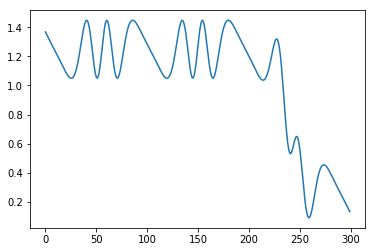

In [3]:
x=art_ser(300, noise=.0, season=.2)
plt.plot(x)

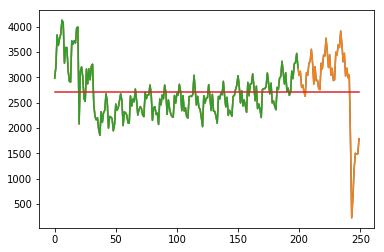

0.000, 2717.498


In [4]:
ns=10
rt=False
#data=collect[ser[ns]].dropna().values
data=pd.read_csv('../_DataSets/Air Passengers.csv')['mpass'].values #полёты на Америке 2000-2020 по месяцам
x, a, b = RemTrend(data) if rt else (data-data.mean(), 0., data.mean())
bound=50
row=x[:-bound]
t=np.arange(len(x))
plt.figure(facecolor='w')
plt.plot(data)
plt.plot(x+data.mean())
plt.plot(row+data.mean())
plt.plot(t, a*t+b)
plt.show()
print('%.3f, %.3f'%(a,b))

In [5]:
mindist=.01
demb,_,_=DimEmb(row)
depth=demb*2+1
traject=pd.DataFrame(columns=['step']+['t-'+str(j) for j in range(depth-1,-1,-1)])
traject['step']=np.arange(len(row)-depth)
for i in range(len(row)-depth):
    traject.loc[i, traject.columns[1:]]=row[i:i+depth]
'''матрица связей для кластеризации'''
link = linkage(traject[traject.columns[1:]], 'ward', 'euclidean')
'''оптимальное расстояние для кластеризации'''
dist = link[:, 2]
dist_rev = dist[::-1]
i=np.where(np.abs(dist_rev[:-5]-dist_rev[5:])<(max(dist_rev)*mindist))[0][0]
d=dist_rev[i]
'''кластеризация'''
traject['cluster']=fcluster(link, d, criterion='distance')
traject['cluster']=[list(traject['cluster'].drop_duplicates().values).index(i)+1 for i in traject['cluster']]
'''делание графа'''  
G0=make_gr(traject)
print('Done!')

Done!


,step,t-2,t-1,t-0
0,197,320.710653,403.201899,89.581846
1,198,403.201899,89.581846,133.109442
2,199,89.581846,133.109442,0.002886
3,200,133.109442,0.002886,-88.657289
4,201,0.002886,-88.657289,378.961341
5,202,-88.657289,378.961341,322.106297
6,203,378.961341,322.106297,562.60916
7,204,322.106297,562.60916,598.596577
8,205,562.60916,598.596577,839.058799
9,206,598.596577,839.058799,568.618887


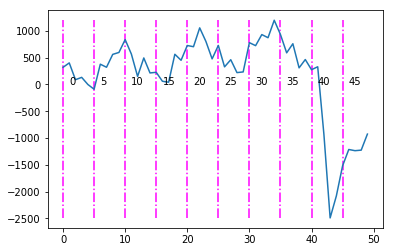

In [6]:
row=x[-bound:]
plt.figure(facecolor='w')
plt.plot(row)
plt.vlines([k for k in range(0,bound,bound//10)], min(row), max(row), color='magenta', linestyle='-.')
for k in np.arange(0,bound,bound//10):
    plt.text(k+1, .1, str(k))
trj=pd.DataFrame(columns=['step']+['t-'+str(j) for j in range(depth-1,-1,-1)])
trj['step']=np.arange(len(row)-depth)+traject['step'].max()+1
for i in range(len(row)-depth):
    trj.loc[i, trj.columns[1:]]=row[i:i+depth]
trj.head(10)

In [7]:
centres={}
gra=[]
gra.append(G0)
for c in traject.cluster.unique():
    centres[c]=traject[traject.cluster==c][traject.columns[1:-1]].values.mean(axis=0)
for k in range(0,bound,bound//5):
    print(k, end='->')
    for i in trj.index[k:k+20]:
        step=trj.loc[i, trj.columns[1:]].values
        for j in centres.keys():
            if d >= np.linalg.norm(step-centres[j]):
                newclust=j
                break
        else:
            newclust=traject.cluster.max()+1        
            print('New node # %i appeared!'%newclust, end='->')
        traject=traject.append(trj.loc[i],ignore_index=True)
        traject.loc[traject.step==trj.loc[i].step, 'cluster']=newclust
        centres={}
        for c in traject.cluster.unique():
            centres[c]=traject[traject.cluster==c][traject.columns[1:-1]].values.mean(axis=0)
    traject.cluster=traject.cluster.astype(int)
    gra.append(make_gr(traject))
print('')
for c in traject.cluster.unique():
    print('Cluster %i - %i points'%(c, len(traject[traject.cluster==c])))

0->10->20->30->New node # 22 appeared!->New node # 23 appeared!->New node # 24 appeared!->New node # 25 appeared!->40->
Cluster 1 - 61 points
Cluster 2 - 9 points
Cluster 3 - 8 points
Cluster 4 - 3 points
Cluster 5 - 8 points
Cluster 6 - 7 points
Cluster 7 - 1 points
Cluster 8 - 1 points
Cluster 9 - 1 points
Cluster 10 - 10 points
Cluster 11 - 14 points
Cluster 12 - 23 points
Cluster 13 - 9 points
Cluster 14 - 26 points
Cluster 15 - 13 points
Cluster 16 - 9 points
Cluster 17 - 13 points
Cluster 18 - 12 points
Cluster 19 - 17 points
Cluster 20 - 15 points
Cluster 21 - 9 points
Cluster 22 - 2 points
Cluster 23 - 2 points
Cluster 24 - 4 points
Cluster 25 - 4 points


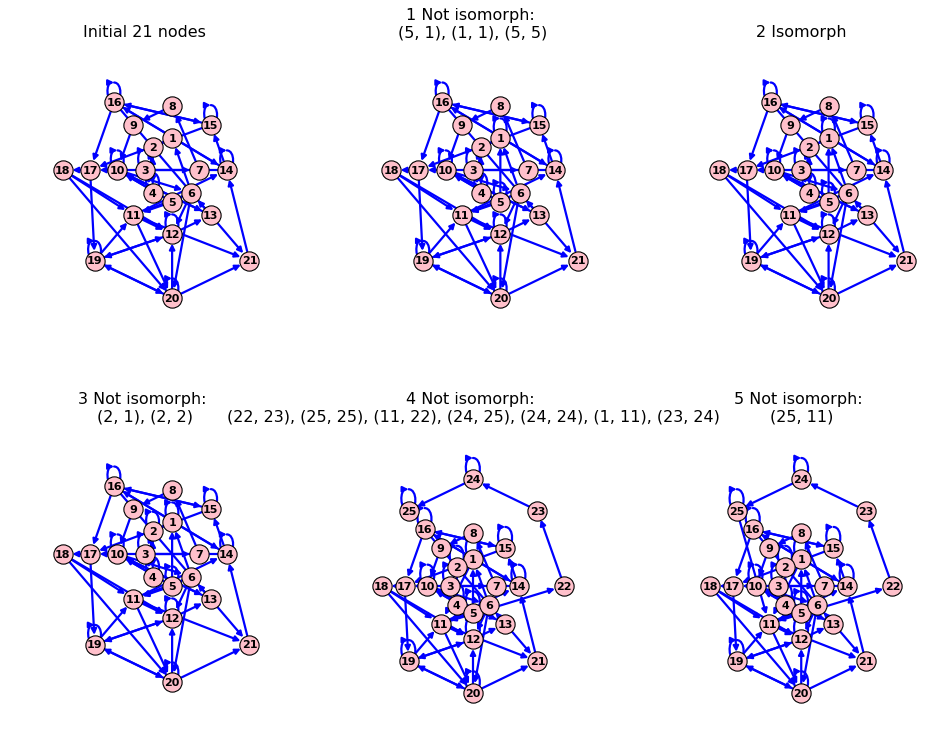

In [8]:
show=True
if show:
    matplotlib.style.use('classic')
    fig=plt.figure(figsize=(15, 35))
    lnd=gra[-1].number_of_nodes()+1
    nnd=lnd//7
    nlist=[range(i,i+lnd//nnd) for i in range(0,lnd-lnd//nnd,lnd//nnd)]+[range(lnd-lnd//nnd,lnd)]
    for i, g in enumerate(gra):
        plt.subplot(len(gra),3,i+1)
        if i:
            e1=set(gra[i-1].edges()) 
            e2=set(g.edges()) 
            plt.title(str(i)+' Isomorph' if nx.is_isomorphic(gra[i-1], g) else str(i)+' Not isomorph: \n'+str(e2.difference(e1))[1:-1])
        else:
            plt.title('Initial %i nodes'%g.number_of_nodes())
        nx.draw(g, pos=nx.shell_layout(g, nlist=nlist),
                   with_labels=True,
                   node_color='pink', font_weight='bold',font_size=10,
                   edge_color='b',node_size=300, width=2 )
    #fig.tight_layout()
    
    #plt.savefig('GrowingGraph.png', dpi=600, facecolor='w', edgecolor='w')
    plt.show()
else:
    for i, g in enumerate(gra):
        if i:
            e1=set(gra[i-1].edges()) 
            e2=set(g.edges()) 
            print(i,'Isomorph' if nx.is_isomorphic(gra[i-1], g) else 'Not isomorph: %i nodes, new edges: '%g.number_of_nodes()+str(e2.difference(e1))[1:-1])
        else:
            print(i,('Initial %i nodes'%g.number_of_nodes()) )

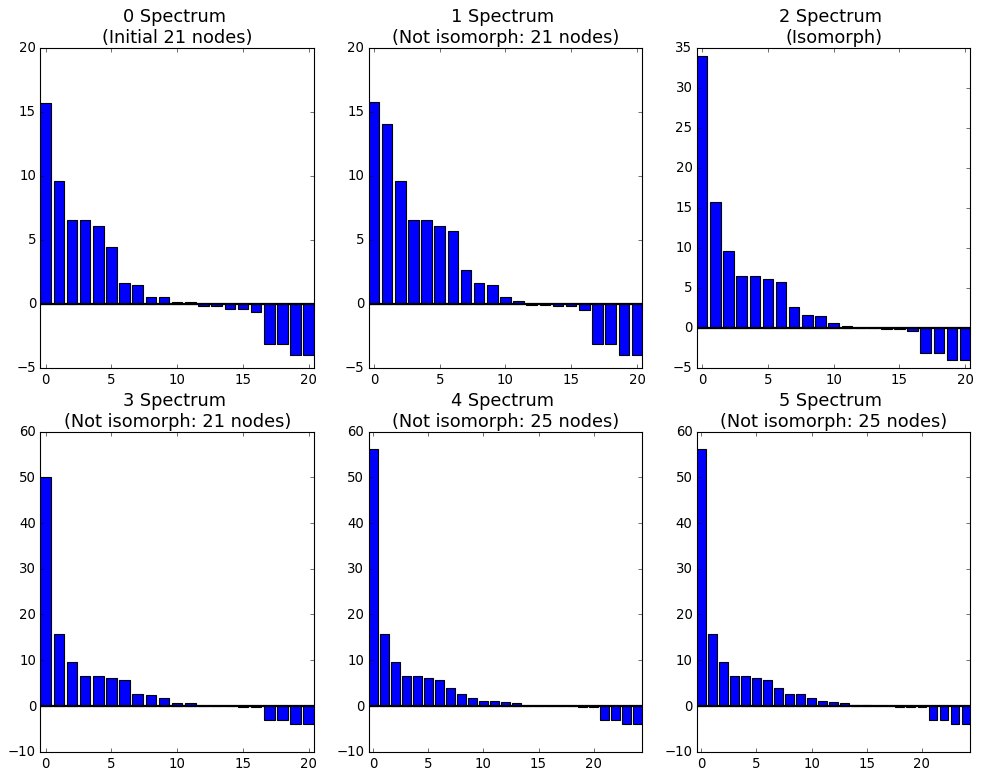

In [9]:
fig=plt.figure(figsize=(15, 35), facecolor='w')
matplotlib.style.use('fast')
for i, g in enumerate(gra):
    plt.subplot(len(gra),3,i+1)
    m = AdjMatr(g, paint=False)
    en, ev=np.linalg.eig(m)
    n=len(en)
    if i:
        isom ='Isomorph' if nx.is_isomorphic(gra[i-1], g) else 'Not isomorph: %i nodes'%g.number_of_nodes()
    else:
        isom ='Initial %i nodes'%g.number_of_nodes()
    plt.title("%d Spectrum \n(%s)"%(i, isom), size=16)
    plt.bar(np.arange(n), np.sort(en.real)[::-1], width=.8)
    plt.xlim(-.4, g.number_of_nodes()-.6 )
    plt.axhline(0, lw=2, c='black')
plt.show()

In [10]:
g=dict(G0.edges())
print(tabulate(zip(g.keys(), list(g.values())), headers=['edge', 'weight'], tablefmt="pretty", stralign=['left']))

+----------+----------------+
|     edge |         weight |
+----------+----------------+
| (1, 2)   | {'weight': 2}  |
| (2, 3)   | {'weight': 2}  |
| (2, 4)   | {'weight': 1}  |
| (3, 3)   | {'weight': 6}  |
| (3, 4)   | {'weight': 1}  |
| (3, 7)   | {'weight': 1}  |
| (4, 4)   | {'weight': 1}  |
| (4, 2)   | {'weight': 1}  |
| (4, 5)   | {'weight': 1}  |
| (5, 6)   | {'weight': 1}  |
| (5, 11)  | {'weight': 1}  |
| (5, 10)  | {'weight': 1}  |
| (6, 1)   | {'weight': 1}  |
| (6, 11)  | {'weight': 1}  |
| (6, 20)  | {'weight': 1}  |
| (6, 12)  | {'weight': 4}  |
| (7, 8)   | {'weight': 1}  |
| (8, 9)   | {'weight': 1}  |
| (9, 10)  | {'weight': 1}  |
| (10, 6)  | {'weight': 1}  |
| (10, 13) | {'weight': 2}  |
| (10, 10) | {'weight': 4}  |
| (10, 5)  | {'weight': 2}  |
| (11, 12) | {'weight': 1}  |
| (11, 14) | {'weight': 5}  |
| (11, 20) | {'weight': 4}  |
| (11, 21) | {'weight': 2}  |
| (12, 13) | {'weight': 7}  |
| (12, 19) | {'weight': 8}  |
| (12, 12) | {'weight': 8}  |
| (13, 10)